In [8]:
# src: https://github.com/Cloud-RF/Signal-Server/blob/master/models/sui.cc

In [43]:
import math
from math import sin, cos, sqrt, atan2, radians
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from matplotlib import colors
from mpl_toolkits.mplot3d import Axes3D
import pymap3d as pm

In [28]:
def dist_bw_coords(lat1,long1,lat2,long2):
    #src: https://stackoverflow.com/questions/19412462/getting-distance-between-two-points-based-on-latitude-longitude
    #simple haversine calculation
    
    # approximate radius of earth in km
    R = 6373.0
    #convert degree lat/longs to radians for computational purposes
    lat1 = radians(abs(lat1))
    long1 = radians(abs(long1))
    lat2 = radians(abs(lat2))
    long2 = radians(abs(long2))
    
    dlon = long2 - long1
    dlat = lat2 - lat1

    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))

    distance = R * c
    #in km
    return distance

In [44]:
def dist(lat1,lon1,alt1,lat2,lon2,alt2):
    az,el,range = pm.geodetic2aer(lat1, lon1, alt1, lat2, lon2, alt2)
    return range

In [2]:
def f_20log10f(x):
    return(8.685889*math.log(x))

In [57]:
def rf_est(lats,longs,alts, freq, tLat, tLong, TxH):
    ests = []
    dists = []
    for i in range(0,len(lats)):
        #tower as first coord, estimation point location second coord
        lat = lats[i]
        long = longs[i]
        alt = alts[i]
        d = dist_bw_coords(tLat,tLong, lat, long)
        pathloss = SUIpathloss(freq, TxH, alt, d, 3)
        
        ests.append(est_freq)
        dists.append(d)
    
    return dists, ests

In [19]:
def SUIpathloss(f, TxH, RxH, d, mode):
    """ 
    f = Frequency (MHz) 1900 to 11000
     TxH =  Transmitter height (m)
     RxH = Receiver height (m)
     d = distance (km)
     mode A1 = URBAN / OBSTRUCTED
     mode B2 = SUBURBAN / PARTIALLY OBSTRUCTED
     mode C3 = RURAL / OPEN 
    """
    d *= 1e3; # km to m
    
    a = 4.6
    b = 0.0065
    c = 12.6
    s = 8.2
    XhCF = -10.8
    
    if mode == 2:
        a = 4.0
        b = 0.0065
        c = 17.1
        XhCF = -10.8
    elif mode == 3:
        a = 3.5
        b = 0.005
        c = 20
        XhCF = -20
        
    d0 = 100.0
    poop = (4*math.pi *d0)/(300.0/f)
    A = f_20log10f(poop)
    y = a -(b*TxH)+(c/TxH)
    
    Xf = 0
    Xh = 0
    
    if f>2000:
        Xf = 6.0 + math.log10(f/2.0)
        Xh = XhCF * math.log10(RxH/2.0)
    
    return (A + (10*y) * (math.log10(d/d0) + Xf + Xh + s))

In [4]:
# parser function
def parser(fname):
    f = open(fname, "r")
    readings = []
    
    for line in f:
        temp = line.strip("\n").split(",")
                #datetime,lat,long,alt,vel_x,vel_y,vel_z,acc_x,elevation,
                    #source,location,vehicle,device,freq,sig_strength,sig_strength_Dbm
        temp2 = [temp[0], float(temp[1]), float(temp[2]), float(temp[3]), float(temp[4]), float(temp[5]), float(temp[6]), temp[7], float(temp[8]),
                    int(temp[9]), int(temp[10]), int(temp[11]), int(temp[12]), float(temp[13]), float(temp[14]), float(temp[15])]
        readings.append(temp2)
    f.close()
    return readings

In [7]:
def extract(arr, ind):
    temp = []
    for i in arr:
        temp.append(i[ind])
        
    return temp

In [5]:
# ID, Loop#, Timestamp, Freq, Lat, Long, RF reading
readings = parser("../data/channel14_470mhz.log")

In [8]:
lats = extract(readings,1)
longs = extract(readings, 2)
alt = extract(readings, 3)
sig_strengths = extract(readings, 15)

In [50]:
tmp = zip(lats,longs,alt)
tmp

In [32]:
#tower location
towerlat = 33.147217
towerlong = -116.656758
toweralt = 12.192 #meters (40 ft)

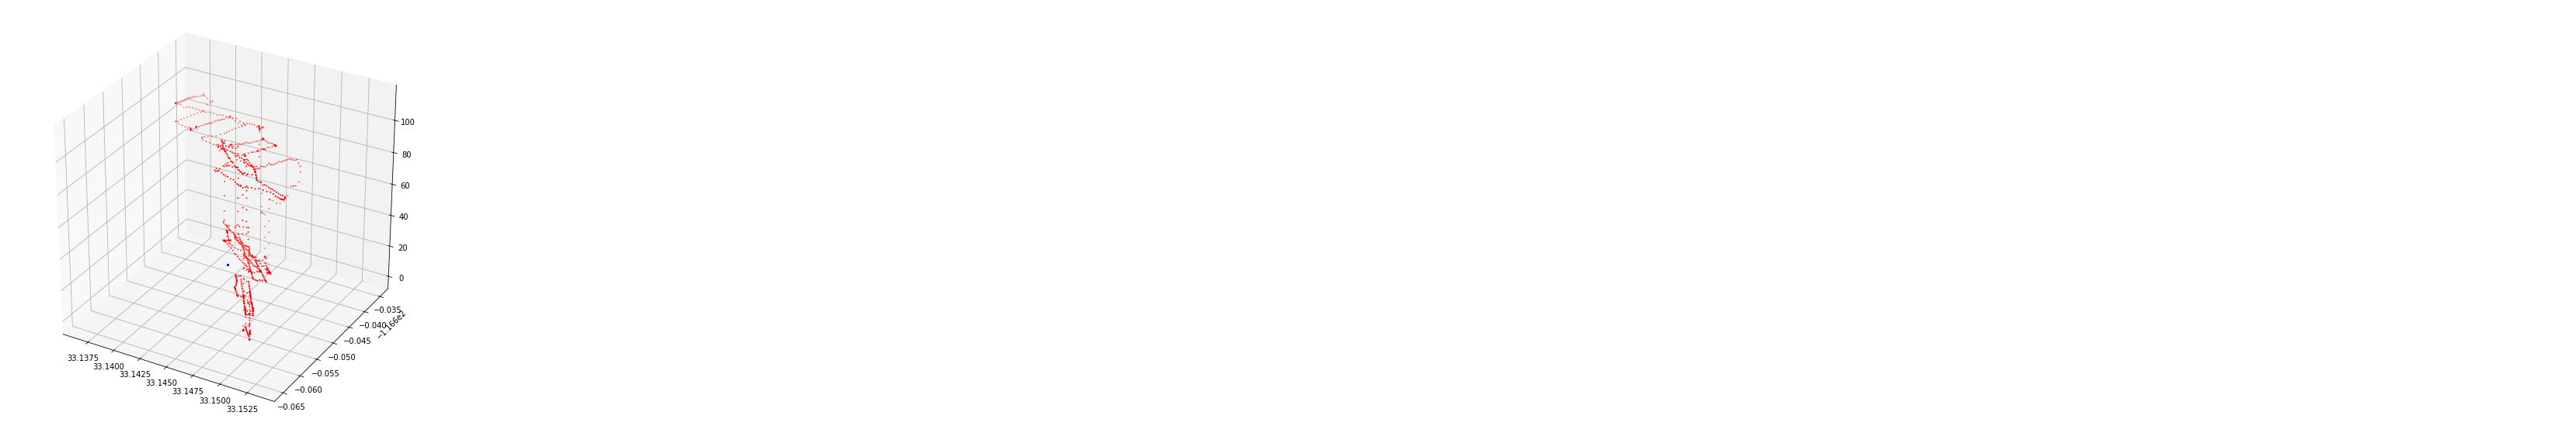

In [42]:
figdata = plt.figure(figsize=(10,10))  # create a figure object
ax = figdata.add_subplot(111, projection='3d')  # create an axes object in the figure
ax.scatter(lats,longs,alt, s=1, color="red")
ax.scatter([towerlat],[towerlong],[40], s=5, color="blue")
figdata.savefig('3ddata_wtower.png', dpi=300)

In [38]:
r = SUIpathloss(1540, 1000, 100, 150, 3)

In [53]:
readings[0][13]

470.309

## Test the error in the SUI model
1. use the four tower sites and apply the SUI model to find the signal strength at the data point locations
2. compare the estimated values to the actual values from the data

In [58]:
dists, ests = rf_est(lats,longs,alt, readings[0][13], towerlat, towerlong, toweralt)

In [59]:
def abs_error(ests, real):
    errors = []
    for i in range(0,len(real)):
        errors.append(abs(real[i]-ests[i]))
    return errors

In [60]:
error = abs_error(ests,sig_strengths)

In [62]:
ests

[507.00335377346323,
 507.00335377346323,
 507.00335377346323,
 507.00335377346323,
 507.00335377346323,
 507.00335377346323,
 507.00335377346323,
 507.00335377346323,
 507.00335377346323,
 507.00335377346323,
 507.00335377346323,
 507.00335377346323,
 507.00335377346323,
 507.00335377346323,
 507.0034766713128,
 507.0039448916518,
 507.00463168016825,
 507.0055843960573,
 507.00682601785036,
 507.0082585708225,
 507.00970496665747,
 507.0113365354029,
 507.012942758342,
 507.01461098837547,
 507.0161799631487,
 507.0176822700421,
 507.0190607186112,
 507.02039141447574,
 507.02170706171376,
 507.0237114249867,
 507.02420691570967,
 507.02003790665725,
 507.0080769505905,
 507.0169007187458,
 507.00776041853055,
 507.0148440070378,
 507.02153572653697,
 507.0134955922297,
 507.0179591086936,
 507.0212137650949,
 507.01982754018303,
 507.0204872069442,
 507.0341182266018,
 507.0191544769266,
 507.0279742061606,
 507.0228906988043,
 507.02672397988727,
 507.03020392625655,
 507.020921124

In [63]:
sig_strengths

[-68.905501174,
 -71.87737912,
 -73.583548772,
 -69.623606106,
 -73.362040034,
 -72.54624369,
 -72.820102176,
 -69.855008238,
 -71.74373297,
 -74.557929718,
 -75.237984522,
 -73.133110872,
 -73.026022726,
 -72.368576376,
 -73.277429794,
 -73.672438716,
 -72.204389562,
 -72.56412309,
 -73.36004775800001,
 -69.9652427,
 -73.716246084,
 -73.670836192,
 -72.25531558,
 -67.193437056,
 -71.13608879,
 -67.43273427599999,
 -71.346021326,
 -73.734383742,
 -72.729614438,
 -71.830253184,
 -69.534917146,
 -71.958445644,
 -68.091762864,
 -69.910175266,
 -71.916360942,
 -65.056107564,
 -68.385723106,
 -71.670119034,
 -69.660799938,
 -68.097054424,
 -71.064929724,
 -73.703767398,
 -69.714339258,
 -71.65220368600001,
 -71.36401803,
 -67.88786779,
 -67.803078086,
 -69.272291792,
 -67.129633518,
 -68.759460154,
 -71.245197592,
 -69.57152448,
 -69.28758098,
 -69.01637847,
 -68.626873378,
 -69.059624398,
 -69.125062686,
 -65.739944112,
 -68.46935591,
 -69.532749216,
 -68.469886072,
 -64.758009644,
 -68.67